## Les dates clés du COVID en France

- 2020-02-15 au 2020-03-17 : Premières restrictions
- 2020-03-17 au 2020-05-11 : Premier confinement
- 2020-10-30 au 2020-12-15 : Deuxième confinement
- 2021-01-16 au 2021-04-03 : Couvre-feu
- 2021-04-03 au 2021-05-19 : Troisième confinement

## Consommation d'électricité pour la France en MW/h

In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
import pytz
import datetime

In [2]:
df_source = pd.read_csv("Datasets/consommation-quotidienne-brute.csv", delimiter=";")

In [3]:
df_source.tail(1)

,Date - Heure,Date,Heure,Consommation brute gaz (MW PCS 0°C) - GRTgaz,Statut - GRTgaz,Consommation brute gaz (MW PCS 0°C) - Teréga,Statut - Teréga,Consommation brute gaz totale (MW PCS 0°C),Consommation brute électricité (MW) - RTE,Statut - RTE,Consommation brute totale (MW)
192862,2012-01-01T00:00:00+01:00,01/01/2012,00:00,52099.0,Définitif,3254.0,Définitif,55353.0,59610.0,Définitif,114963.0


In [6]:
df_source.iloc[:1]

,Date - Heure,Date,Heure,Consommation brute gaz (MW PCS 0°C) - GRTgaz,Statut - GRTgaz,Consommation brute gaz (MW PCS 0°C) - Teréga,Statut - Teréga,Consommation brute gaz totale (MW PCS 0°C),Consommation brute électricité (MW) - RTE,Statut - RTE,Consommation brute totale (MW)
0,2022-12-31T23:30:00+01:00,31/12/2022,23:30,NaN,NaN,NaN,NaN,NaN,NaN,Consolidé,NaN


In [34]:
df_energie = df_source.drop(columns=[
    "Date","Heure",
    "Consommation brute gaz (MW PCS 0°C) - GRTgaz",
    "Statut - GRTgaz","Consommation brute gaz (MW PCS 0°C) - Teréga",
    "Statut - Teréga"])

In [35]:
df_energie.columns=["Date","Conso_gaz_totale_MW","Conso_elec_totale_MW","Statut","Conso_brute_totale_MW"]

In [36]:
# Convertit la colonne date au format Str. 
# utc n'est que True ou False
df_energie["Date"] = pd.to_datetime(df_energie["Date"], utc=True)
# On repasse donc en heure FR
df_energie["Date"] = df_energie["Date"].dt.tz_convert('Europe/Paris')

In [37]:
# Les données sont en ordre décroissant, les plus récentes en 1er.
# On se replace en ordre chronologique
df_energie.sort_values(by=["Date"], ascending=True, inplace=True)
df_energie.reset_index(drop=True, inplace=True)

In [38]:
# passage de la colonne date en index
df_energie.set_index('Date', inplace=True)

In [39]:
# Les mesures de ce Dataset sont arrêtées au 31/12/2022
df_energie = df_energie.loc [ df_energie.index < "2022-12-31" ]

In [40]:
df_energie = df_energie.loc [ df_energie.index < "2022-12-31" ]

df_energie["Conso_gaz_totale_MW"] = df_energie["Conso_gaz_totale_MW"].interpolate(method='linear', axis=0)
df_energie["Conso_brute_totale_MW"] = df_energie["Conso_brute_totale_MW"].interpolate(method='linear', axis=0)

In [41]:
df_energie.head()

,Conso_gaz_totale_MW,Conso_elec_totale_MW,Statut,Conso_brute_totale_MW
Date,,,,
2012-01-01 00:00:00+01:00,55353.0,59610.0,Définitif,114963.0
2012-01-01 00:30:00+01:00,55398.5,58314.0,Définitif,113318.5
2012-01-01 01:00:00+01:00,55444.0,56230.0,Définitif,111674.0
2012-01-01 01:30:00+01:00,55454.5,56075.0,Définitif,111335.0
2012-01-01 02:00:00+01:00,55465.0,55531.0,Définitif,110996.0


In [42]:
# Vérification que plus aucune ligne n'est vide
df_energie.isna().sum()

Conso_gaz_totale_MW      0
Conso_elec_totale_MW     0
Statut                   0
Conso_brute_totale_MW    0
dtype: int64

In [43]:
print("Nombre de lignes sur la période 2012-2022 : ",df_energie.shape[0])

Nombre de lignes sur la période 2012-2022 :  182592


In [44]:
rolling_max_7j = df_energie["Conso_elec_totale_MW"].rolling(
    window=336,       # Moyenne mobile Hebdo (48x30mn x 7j)
    center=True,      
    min_periods=168,  # débute à la moitié de la fenêtre définie
).max()

In [45]:
df_energie["MA_max_7j"] = rolling_max_7j

In [46]:
df_energie.describe()

,Conso_gaz_totale_MW,Conso_elec_totale_MW,Conso_brute_totale_MW,MA_max_7j
count,182592.000000,182592.000000,182592.000000,182592.000000
mean,54018.475664,54144.101330,108160.623171,65628.655927
std,28978.525136,12022.053534,40087.315950,11786.136991
min,1877.000000,28738.000000,45476.000000,47454.000000
25%,28523.000000,44998.000000,74817.000000,55643.000000
50%,47047.750000,52510.000000,97884.000000,61956.000000
75%,76023.125000,62412.000000,138092.625000,75572.000000
max,176040.000000,101866.000000,274815.000000,101866.000000


In [47]:
df_last_3y = df_energie.loc[df_energie.index >= '2018-01-01']

In [66]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=['2020-02-15', '2020-03-17'], 
    y=[100000, 100000], 
    fill='tozeroy', 
    name='Premières restrictions'
))

fig.add_trace(go.Scatter(
    x=['2020-03-17', '2020-05-11'], 
    y=[100000, 100000], 
    fill='tozeroy', 
    name='Premier confinement'
))

fig.add_trace(go.Scatter(
    x=['2020-10-30', '2020-12-15'], 
    y=[100000, 100000], 
    fill='tozeroy', 
    name='Deuxième confinement'
))

fig.add_trace(go.Scatter(
    x=['2021-01-16', '2021-04-03'], 
    y=[100000, 100000], 
    fill='tozeroy', 
    name='Couvre-feu'
))

fig.add_trace(go.Scatter(
    x=['2021-04-03', '2021-05-19'], 
    y=[100000, 100000], 
    fill='tozeroy', 
    name='Troisième confinement'
))

fig.add_trace(go.Scatter(
    x=df_last_3y.index, 
    y=df_last_3y["Conso_elec_totale_MW"],
    mode='markers',
    name='Mesures brutes',
    marker_color=df_last_3y["Conso_elec_totale_MW"],
    marker=dict(opacity=0.1,size=2)
))

fig.add_trace(go.Scatter(
    x=df_last_3y.index, 
    y=df_last_3y["MA_max_7j"],
    mode='lines',
    name='Moy. Mobile Max hebdo'
))

#fig.layout.plot_bgcolor = '#DCDCDC'

fig.update_layout(title='Consommation electrique en MW depuis 2018 en France')

# Permet d'exporter le graphique intéractif en format png
from kaleido.scopes.plotly import PlotlyScope

scope = PlotlyScope(plotlyjs="https://cdn.plot.ly/plotly-latest.min.js")

with open("Graphs/Conso_elec_totale_MW.png", "wb") as f:
    f.write(scope.transform(fig, format="png"))
    
#fig.write_image("Graphs/Conso_elec_totale_MW.png", format="png", engine="kaleido")
#fig.show()

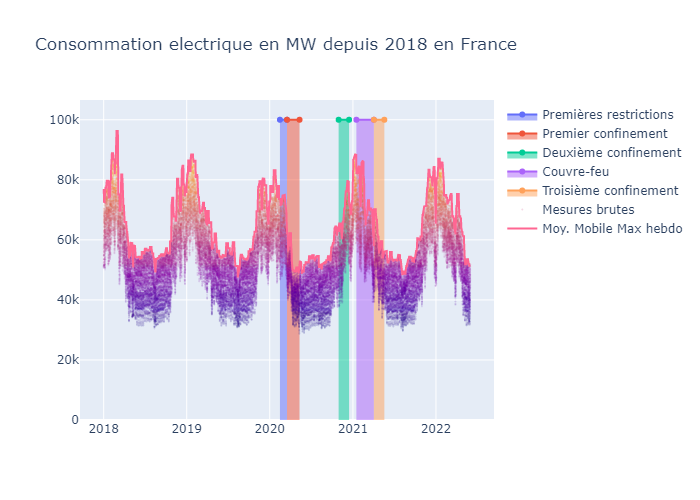

In [67]:
from IPython.display import Image
Image(filename="Graphs/Conso_elec_totale_MW.png") 

## Consommation de gaz pour la France en MW/h

In [75]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=['2020-02-15', '2020-03-17'], 
    y=[160000, 160000], 
    fill='tozeroy', 
    name='Premières restrictions'
))

fig.add_trace(go.Scatter(
    x=['2020-03-17', '2020-05-11'], 
    y=[160000, 160000], 
    fill='tozeroy', 
    name='Premier confinement'
))

fig.add_trace(go.Scatter(
    x=['2020-10-30', '2020-12-15'], 
    y=[160000, 160000], 
    fill='tozeroy', 
    name='Deuxième confinement'
))

fig.add_trace(go.Scatter(
    x=['2021-01-16', '2021-04-03'], 
    y=[160000, 160000], 
    fill='tozeroy', 
    name='Couvre-feu'
))

fig.add_trace(go.Scatter(
    x=['2021-04-03', '2021-05-19'], 
    y=[160000, 160000], 
    fill='tozeroy', 
    name='Troisième confinement'
))

fig.add_trace(go.Scatter(
    x=df_last_3y.index, 
    y=df_last_3y["Conso_gaz_totale_MW"],
    mode='markers',
    name='Mesures brutes',
    marker_color=df_last_3y["Conso_gaz_totale_MW"],
    marker=dict(opacity=0.1,size=2)
))

fig.add_trace(go.Scatter(
    x=df_last_3y.index, 
    y=df_last_3y["MA_max_7j"],
    mode='lines',
    name='Moy. Mobile Max hebdo'
))

fig.update_layout(title='Consommation gaz en MW depuis 2018 en France')

with open("Graphs/Conso_gaz_totale_MW.png", "wb") as f:
    f.write(scope.transform(fig, format="png"))

#fig.write_image("Graphs/Conso_gaz_totale_MW.png")
#fig.show()

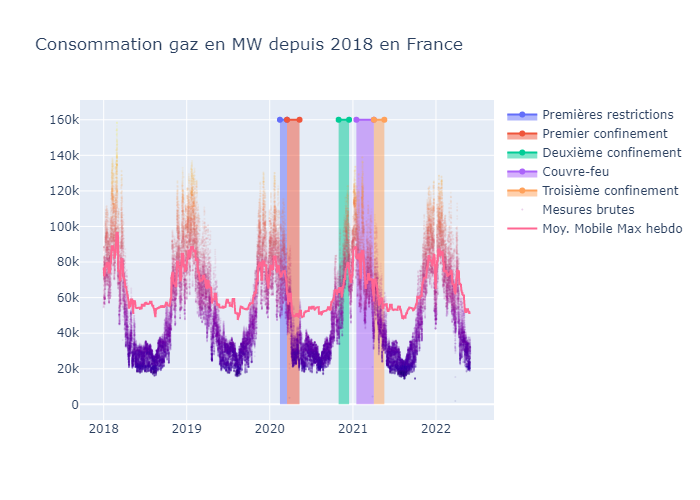

In [76]:
Image(filename="Graphs/Conso_gaz_totale_MW.png") 